In [2]:
import os
import random
from typing import Callable, Optional, TypedDict
from matplotlib import pyplot as plt
import numpy as np
from obp.dataset import SyntheticBanditDataset
from obp.ope import ReplayMethod, InverseProbabilityWeighting, BaseOffPolicyEstimator
import polars as pl

# current directory をリポジトリルートに固定
os.chdir("/Users/masato.morita/src/recommender-experiments/")

# グラフに日本語を表示するために、日本語対応のフォントを設定 (例: IPAexゴシック)
plt.rcParams["font.family"] = "IPAexGothic"
print(plt.rcParams["font.family"])
import japanize_matplotlib

['IPAexGothic']


In [3]:
class BanditFeedbackDict(TypedDict):
    n_rounds: int  # ラウンド数
    n_actions: int  # アクション数s
    context: np.ndarray  # 文脈 (shape: (n_rounds, dim_context))
    action_context: (
        np.ndarray
    )  # アクション特徴量 (shape: (n_actions, dim_action_features))
    action: np.ndarray  # 実際に選択されたアクション (shape: (n_rounds,))
    position: Optional[np.ndarray]  # ポジション (shape: (n_rounds,) or None)
    reward: np.ndarray  # 報酬 (shape: (n_rounds,))
    expected_reward: np.ndarray  # 期待報酬 (shape: (n_rounds, n_actions))
    pi_b: np.ndarray  # データ収集方策 P(a|x) (shape: (n_rounds, n_actions))
    pscore: np.ndarray  # 傾向スコア (shape: (n_rounds,))

In [4]:
# 真の期待報酬関数 E_{p(r|x,a)}[r] を定義する
def expected_reward_function(
    context: np.ndarray,
    action_context: np.ndarray,
    random_state: int = None,
) -> np.ndarray:
    """(アクションa, 文脈x)の各組み合わせに対する期待報酬 E_{p(r|x,a)}[r] を定義する関数
    今回の場合は、推薦候補4つの記事を送った場合の報酬rの期待値を、文脈xに依存しない固定値として設定する
    ニュース0: 0.2, ニュース1: 0.15, ニュース2: 0.1, ニュース3: 0.05
    返り値のshape: (n_rounds, n_actions, len_list)
    """
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    # 固定の期待報酬を設定 (n_actions=4として固定値を設定)
    fixed_rewards = np.array([0.4, 0.3, 0.2, 0.2])

    # 文脈の数だけ期待報酬を繰り返して返す
    return np.tile(fixed_rewards, (n_rounds, 1))


# 試しに期待報酬関数を実行してみる
n_rounds = 3
n_actions = 4
context = np.array([[1], [2], [3]])
action_context = np.array([[1], [2], [3], [4]])
print(expected_reward_function(context, action_context))

[[0.4 0.3 0.2 0.2]
 [0.4 0.3 0.2 0.2]
 [0.4 0.3 0.2 0.2]]


In [22]:
# 5種類の推薦方策を定義していく


from typing import Literal


def pi_0(
    context: np.ndarray,
    action_context: np.ndarray,
    random_state: int = None,
) -> np.ndarray:
    """コンテキストを考慮せず、一様ランダムな確率的方策"""
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    # 一様ランダムな確率でアクションを選択
    action_dist = np.full((n_rounds, n_actions), 1 / n_actions)

    assert action_dist.shape == (n_rounds, n_actions)
    return action_dist


def pi_1(
    context: np.ndarray,
    action_context: np.ndarray,
    random_state: int = None,
) -> np.ndarray:
    """コンテキストを考慮せず、全てのユーザに対してニュース $a_1$ を確率1で推薦する決定的方策"""
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    p_scores = np.array([0.0, 1.0, 0.0, 0.0])
    action_dist = np.tile(p_scores, (n_rounds, 1))

    assert action_dist.shape == (n_rounds, n_actions)
    return action_dist


def pi_2(
    context: np.ndarray,
    action_context: np.ndarray,
    random_state: int = None,
) -> np.ndarray:
    """コンテキストを考慮せず、全てのユーザに対してニュース $a_1$ と $a_2$ を確率0.5で推薦する確率的方策"""
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    p_scores = np.array([0.0, 0.5, 0.5, 0.0])
    action_dist = np.tile(p_scores, (n_rounds, 1))

    assert action_dist.shape == (n_rounds, n_actions)
    return action_dist


def pi_3(
    context: np.ndarray,
    action_context: np.ndarray,
    random_state: int = None,
) -> np.ndarray:
    """コンテキストを考慮せず、全てのユーザに対してニュース $a_0$ を確率0.1、
    ニュース $a_1$ を確率0.1、ニュース $a_2$ を確率0.1、ニュース $a_3$ を確率0.7で
    推薦する確率的方策"""
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    p_scores = np.array([0.1, 0.1, 0.1, 0.7])
    action_dist = np.tile(p_scores, (n_rounds, 1))

    assert action_dist.shape == (n_rounds, n_actions)
    return action_dist


def pi_4(
    context: np.ndarray,
    action_context: np.ndarray,
    random_state: int = None,
) -> np.ndarray:
    """ユーザとニュースのコンテキストを考慮し、
    コンテキストベクトル $x$ とアイテムコンテキストベクトル $e$ の内積が最も大きいニュースを
    確率1で推薦する決定的方策"""
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    # 内積を計算
    scores = context @ action_context.T  # shape: (n_rounds, n_actions)

    # 各ラウンドで最もスコアが高いアクションのindexを取得
    selected_actions = np.argmax(scores, axis=1)  # shape: (n_rounds,)

    # 決定的方策: 確率1で最もスコアが高いアクションを選択
    action_dist = np.zeros((n_rounds, n_actions))
    action_dist[np.arange(n_rounds), selected_actions] = 1.0

    return action_dist


def pi_5(
    context: np.ndarray,
    action_context: np.ndarray,
    random_state: int = None,
) -> np.ndarray:
    """ユーザとニュースのコンテキストを考慮し、
    コンテキストベクトル $x$ とアイテムコンテキストベクトル $e$ の内積が最も大きいニュースを
    確率0.7で推薦し、その他のニュースを均等に確率0.1で推薦する確率的方策。
    """
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    # 内積を計算
    scores = context @ action_context.T  # shape: (n_rounds, n_actions)

    # 各ラウンドで最もスコアが高いアクションのindexを取得
    selected_actions = np.argmax(scores, axis=1)  # shape: (n_rounds,)

    # 確率的方策: 確率0.1で全てのアクションを一様ランダムに選択し、確率0.6で最もスコアが高いアクションを決定的に選択
    epsilon = 0.1
    action_dist = np.full((n_rounds, n_actions), epsilon / n_actions)
    action_dist[np.arange(n_rounds), selected_actions] = (
        1.0 - epsilon + epsilon / n_actions
    )
    return action_dist


print(
    pi_5(
        context=np.array([[1], [2], [3]]),
        action_context=np.array([[1], [2], [3], [4]]),
    )
)
print(
    pi_0(
        context=np.array([[1], [2], [3]]),
        action_context=np.array([[1], [2], [3], [4]]),
    )
)

[[0.025 0.025 0.025 0.925]
 [0.025 0.025 0.025 0.925]
 [0.025 0.025 0.025 0.925]]
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


In [6]:
def policy_wrapper(
    base_policy: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    mode: Literal["logging_poicy", "target_policy_name"],
) -> Callable[[np.ndarray, np.ndarray, int], np.ndarray]:
    """
    方策のラッパー関数。データ収集時と評価時で出力の形状を切り替える。
    (logging_policyの場合はshape=(n_rounds, n_actions)、target_policyの場合はshape=(n_rounds,n_actions, 1))
    Parameters
    - base_policy: ベースとなる方策関数
    - mode: 方策のモード。"logging_policy"はデータ収集方策、"target_policy"は評価方策

    Returns
    - wrapされた方策関数
    """

    def wrapped_policy(
        context: np.ndarray,
        action_context: np.ndarray,
        random_state: int = None,
    ) -> np.ndarray:
        action_dist = base_policy(context, action_context, random_state)
        if mode == "logging_policy":
            return action_dist
        elif mode == "target_policy":
            return action_dist[:, :, np.newaxis]

    return wrapped_policy


target_policy_name = policy_wrapper(pi_5, mode="target_policy")
print(
    target_policy_name(
        context=np.array([[1], [2], [3]]), action_context=np.array([[1], [2], [3], [4]])
    )
)

[[[0.025]
  [0.025]
  [0.025]
  [0.925]]

 [[0.025]
  [0.025]
  [0.025]
  [0.925]]

 [[0.025]
  [0.025]
  [0.025]
  [0.925]]]


In [9]:
# 5つの推薦方策をデータ収集方策として、ある一つの評価方策に対してOPEを実行する
def pi_6(
    context: np.ndarray,
    action_context: np.ndarray,
    random_state: int = None,
) -> np.ndarray:
    """ユーザとニュースのコンテキストを考慮し、
    コンテキストベクトル $x$ とアイテムコンテキストベクトル $e$ の内積が最も小さいニュースを
    確率1で推薦する決定的方策 (pi_4とは逆の方策)
    """
    n_rounds = context.shape[0]
    n_actions = action_context.shape[0]

    # 内積を計算
    scores = context @ action_context.T  # shape: (n_rounds, n_actions)

    # 各ラウンドで最もスコアが高いアクションのindexを取得
    selected_actions = np.argmin(scores, axis=1)  # shape: (n_rounds,)

    # 決定的方策: 確率1で最もスコアが高いアクションを選択
    action_dist = np.zeros((n_rounds, n_actions))
    action_dist[np.arange(n_rounds), selected_actions] = 1.0

    return action_dist


def run_single_ope_simulation(
    simulate_idx: int,
    n_rounds: int,
    n_actions: int,
    dim_context: int,
    action_context: np.ndarray,
    reward_function: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    logging_policy_function: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    target_policy_function: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
) -> dict:
    # データ収集方策によって集められるはずの、擬似バンディットデータの設定を定義
    dataset = SyntheticBanditDataset(
        n_actions=n_actions,
        dim_context=dim_context,
        reward_type="binary",
        reward_function=reward_function,
        behavior_policy_function=logging_policy_function,
        random_state=simulate_idx,
        action_context=action_context,
    )
    # 収集されるバンディットフィードバックデータを生成
    bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)

    # bandit_feedbackをpl.DataFrameに変換
    selected_action_contexts = action_context[bandit_feedback["action"], :]
    bandit_feedback_df = pl.DataFrame(
        {
            "time_step": [i for i in range(n_rounds)],
            "context": bandit_feedback["context"].tolist(),
            "action": bandit_feedback["action"].tolist(),
            "action_context": selected_action_contexts.tolist(),
            "reward": bandit_feedback["reward"].tolist(),
            "p_score": bandit_feedback["pscore"].tolist(),
        }
    )

    # 評価方策を使って、ログデータ(bandit_feedback)に対する行動選択確率を計算
    target_policy_action_dist = target_policy_function(
        context=bandit_feedback["context"],
        action_context=bandit_feedback["action_context"],
    )
    # 真の期待報酬E_{p(r|x,a)}[r]を使って、データ収集方策の代わりに評価方策を動かした場合の性能を計算
    ground_truth_policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback["expected_reward"],
        action_dist=target_policy_action_dist,
    )

    # OPE推定量を準備(naive推定量とIPS推定量)
    naive_estimator = ReplayMethod()
    ips_estimator = InverseProbabilityWeighting()

    # それぞれのOPE推定量を使って、データ収集方策の代わりに評価方策を動かした場合の価値を推定
    estimated_policy_value_by_naive = naive_estimator.estimate_policy_value(
        reward=bandit_feedback["reward"],
        action=bandit_feedback["action"],
        action_dist=target_policy_action_dist,
    )
    estimated_policy_value_by_ips = ips_estimator.estimate_policy_value(
        action=bandit_feedback["action"],
        reward=bandit_feedback["reward"],
        action_dist=target_policy_action_dist,
        pscore=bandit_feedback["pscore"],
    )

    return {
        "simulate_idx": simulate_idx,
        "ground_truth_policy_value": ground_truth_policy_value,
        "naive_estimate": estimated_policy_value_by_naive,
        "naive_error": ground_truth_policy_value - estimated_policy_value_by_naive,
        "ips_estimate": estimated_policy_value_by_ips,
        "ips_error": ground_truth_policy_value - estimated_policy_value_by_ips,
    }


# シミュレーションの設定
simulate_idx = 0
n_rounds = 10
n_actions = 4
dim_context = 3
action_context = np.random.random((n_actions, dim_context))
reward_function = expected_reward_function
logging_policy_function = policy_wrapper(pi_1, mode="logging_policy")
target_policy_function = policy_wrapper(pi_6, mode="target_policy")

# シミュレーションを実行
result_dict = run_single_ope_simulation(
    simulate_idx=simulate_idx,
    n_rounds=n_rounds,
    n_actions=n_actions,
    dim_context=dim_context,
    action_context=action_context,
    reward_function=reward_function,
    logging_policy_function=logging_policy_function,
    target_policy_function=target_policy_function,
)
print(result_dict)

{'simulate_idx': 0, 'ground_truth_policy_value': 0.36, 'naive_estimate': 0.0, 'naive_error': 0.36, 'ips_estimate': 0.0, 'ips_error': 0.36}


In [23]:
import itertools

from pandera.polars import DataFrameSchema
from pandera.typing.polars import DataFrame


class SimulationResult(DataFrameSchema):
    logging_policy_name: str
    n_rounds: int
    target_policy_true_value: float
    naive_estimate: float
    naive_error: float
    ips_estimate: float
    ips_error: float


# シミュレーションの設定
def run_multiple_simulations(
    logging_policy_map: dict[str, Callable[[np.ndarray, np.ndarray, int], np.ndarray]],
    target_policy: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    n_rounds_list: list[int] = [50, 100, 200, 300, 400, 500, 1000, 10000],
    n_rounds: int = 10000,
    n_actions: int = 4,
    dim_context: int = 3,
    action_context: np.ndarray = np.random.random((n_actions, dim_context)),
) -> DataFrame[SimulationResult]:

    results = []
    for logging_policy_name in logging_policy_map.keys():
        for n_rounds in n_rounds_list:
            result_dict = run_single_ope_simulation(
                simulate_idx=0,
                n_rounds=n_rounds,
                n_actions=n_actions,
                dim_context=dim_context,
                action_context=action_context,
                reward_function=expected_reward_function,
                logging_policy_function=policy_wrapper(
                    logging_policy_map[logging_policy_name], mode="logging_policy"
                ),
                target_policy_function=policy_wrapper(
                    target_policy, mode="target_policy"
                ),
            )
            results.append(
                {
                    "logging_policy_name": logging_policy_name,
                    "n_rounds": n_rounds,
                    "target_policy_true_value": result_dict[
                        "ground_truth_policy_value"
                    ],
                    "naive_estimate": result_dict["naive_estimate"],
                    "naive_error": result_dict["naive_error"],
                    "ips_estimate": result_dict["ips_estimate"],
                    "ips_error": result_dict["ips_error"],
                }
            )
    return pl.DataFrame(results)


policy_map = {
    "pi_0": pi_0,
    "pi_1": pi_1,
    "pi_2": pi_2,
    "pi_3": pi_3,
    "pi_4": pi_4,
    "pi_5": pi_5,
}
result_df = run_multiple_simulations(
    policy_map,
    pi_6,
    n_rounds_list=list(range(50, 5000, 50)),
)
print(result_df)

shape: (594, 7)
┌───────────────┬──────────┬───────────────┬──────────────┬─────────────┬──────────────┬───────────┐
│ logging_polic ┆ n_rounds ┆ target_policy ┆ naive_estima ┆ naive_error ┆ ips_estimate ┆ ips_error │
│ y_name        ┆ ---      ┆ _true_value   ┆ te           ┆ ---         ┆ ---          ┆ ---       │
│ ---           ┆ i64      ┆ ---           ┆ ---          ┆ f64         ┆ f64          ┆ f64       │
│ str           ┆          ┆ f64           ┆ f64          ┆             ┆              ┆           │
╞═══════════════╪══════════╪═══════════════╪══════════════╪═════════════╪══════════════╪═══════════╡
│ pi_0          ┆ 50       ┆ 0.326         ┆ 0.272727     ┆ 0.053273    ┆ 0.24         ┆ 0.086     │
│ pi_0          ┆ 100      ┆ 0.328         ┆ 0.333333     ┆ -0.005333   ┆ 0.36         ┆ -0.032    │
│ pi_0          ┆ 150      ┆ 0.330667      ┆ 0.236842     ┆ 0.093825    ┆ 0.24         ┆ 0.090667  │
│ pi_0          ┆ 200      ┆ 0.3325        ┆ 0.411765     ┆ -0.079265   ┆ 0

In [24]:
# 小数点以下4桁までに丸める
rounded_opl_result_df = result_df.with_columns(
    [
        result_df["naive_estimate"].round(4).alias("naive_estimate"),
        result_df["naive_error"].round(4).alias("naive_error"),
        result_df["ips_estimate"].round(4).alias("ips_estimate"),
        result_df["ips_error"].round(4).alias("ips_error"),
    ]
)
display(rounded_opl_result_df)

# 結果をcsvファイルに保存
rounded_opl_result_df.write_csv("logs/logging_policy_experiment/ope_result.csv")

logging_policy_name,n_rounds,target_policy_true_value,naive_estimate,naive_error,ips_estimate,ips_error
str,i64,f64,f64,f64,f64,f64
"""pi_0""",50,0.326,0.2727,0.0533,0.24,0.086
"""pi_0""",100,0.328,0.3333,-0.0053,0.36,-0.032
"""pi_0""",150,0.330667,0.2368,0.0938,0.24,0.0907
"""pi_0""",200,0.3325,0.4118,-0.0793,0.42,-0.0875
"""pi_0""",250,0.3316,0.3235,0.0081,0.352,-0.0204
…,…,…,…,…,…,…
"""pi_5""",4750,0.333495,0.4188,-0.0853,0.4126,-0.0791
"""pi_5""",4800,0.3335625,0.3025,0.031,0.3,0.0336
"""pi_5""",4850,0.333753,0.3697,-0.036,0.3629,-0.0291


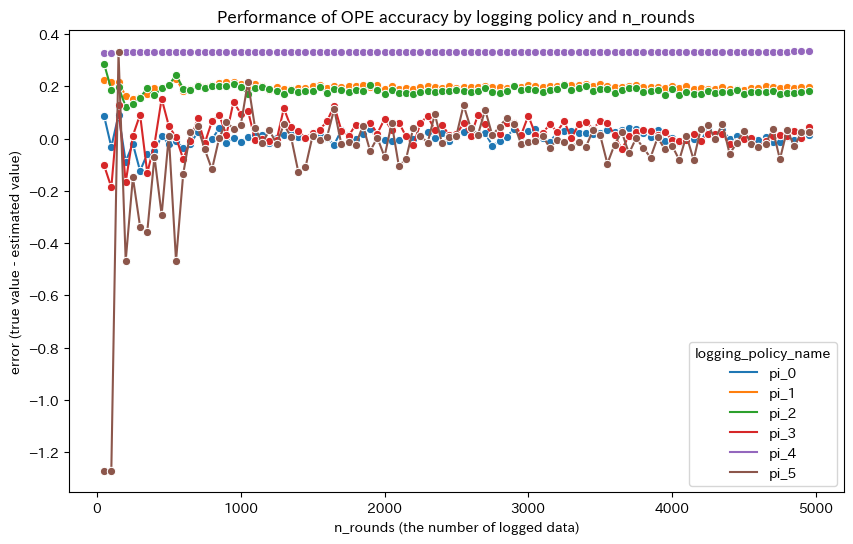

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# 横軸 n_rounds, 縦軸 真の性能 のグラフを描画
# グラフの描画
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=rounded_opl_result_df.to_pandas(),
    x="n_rounds",
    y="ips_error",
    hue="logging_policy_name",
    marker="o",
)
# plt.xscale("log")
plt.xlabel("n_rounds (the number of logged data)")
plt.ylabel("error (true value - estimated value)")
plt.title("Performance of OPE accuracy by logging policy and n_rounds")
plt.legend(title="logging_policy_name")
plt.show()

In [26]:
from obp.policy import IPWLearner, NNPolicyLearner, Random, LogisticTS, BernoulliTS
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


def run_single_opl_simulation(
    simulate_idx: int,
    n_rounds: int,
    n_actions: int,
    dim_context: int,
    action_context: np.ndarray,
    reward_function: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    logging_policy_function: Callable[[np.ndarray, np.ndarray, int], np.ndarray],
    hyperparams: dict = {"base_model": {"max_iter": 1000}},
) -> dict:
    # データ収集方策によって集められるはずの、擬似バンディットデータの設定を定義
    dataset = SyntheticBanditDataset(
        n_actions=n_actions,
        dim_context=dim_context,
        reward_type="binary",
        reward_function=reward_function,
        behavior_policy_function=logging_policy_function,
        random_state=simulate_idx,
        action_context=action_context,
    )
    # 学習用とテスト用のデータセットを生成
    bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=10000)
    bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)
    new_policy = IPWLearner(
        n_actions=n_actions,
        base_classifier=LogisticRegression(**hyperparams["base_model"]),
    )

    new_policy.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

    # オフライン学習した方策を使って、テストデータに対する性能を評価
    ## 各評価方策をテスト用データセットに適用した時のアクション選択確率を算出
    test_action_dist = new_policy.predict(context=bandit_feedback_test["context"])
    ## # 真の即時報酬の期待値を使って、各方策の真の累積報酬の期待値を算出
    ground_truth_policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=test_action_dist,
    )

    return {
        "simulate_idx": simulate_idx,
        "n_rounds": n_rounds,
        "ground_truth_policy_value": ground_truth_policy_value,
    }


# シミュレーションの設定
simulate_idx = 0
n_rounds = 1000
n_actions = 4
dim_context = 3
action_context = np.random.random((n_actions, dim_context))
reward_function = expected_reward_function
logging_policy_function = policy_wrapper(pi_4, mode="logging_policy")


# 1回のシミュレーションを実行
result_dict = run_single_opl_simulation(
    simulate_idx=simulate_idx,
    n_rounds=n_rounds,
    n_actions=n_actions,
    dim_context=dim_context,
    action_context=action_context,
    reward_function=reward_function,
    logging_policy_function=logging_policy_function,
)
print(result_dict)

{'simulate_idx': 0, 'n_rounds': 1000, 'ground_truth_policy_value': 0.27599000000000007}


In [27]:
import itertools

from pandera.polars import DataFrameSchema
from pandera.typing.polars import DataFrame


class SimulationResult(DataFrameSchema):
    logging_policy_name: str
    n_rounds: int
    trained_policy_true_value: float


# 5つの推薦方策について、データ収集方策と評価方策の組み合わせを作って、シミュレーションを実行する


# シミュレーションの設定
def run_multiple_simulations(
    policy_map: dict[str, Callable[[np.ndarray, np.ndarray, int], np.ndarray]],
    n_rounds_list: list[int] = [50, 100, 200, 300, 400, 500, 1000, 10000],
    n_actions: int = 4,
    dim_context: int = 3,
    action_context: np.ndarray = np.random.random((n_actions, dim_context)),
) -> DataFrame[SimulationResult]:
    results = []
    for logging_policy_name in policy_map.keys():
        for n_rounds in n_rounds_list:
            # データ収集方策と評価方策を指定して、シミュレーションを実行
            result_dict = run_single_opl_simulation(
                simulate_idx=0,
                n_rounds=n_rounds,
                n_actions=n_actions,
                dim_context=dim_context,
                action_context=action_context,
                reward_function=expected_reward_function,
                logging_policy_function=policy_wrapper(
                    policy_map[logging_policy_name], mode="logging_policy"
                ),
            )
            results.append(
                {
                    "logging_policy_name": logging_policy_name,
                    "n_rounds": n_rounds,
                    "trained_policy_true_value": result_dict[
                        "ground_truth_policy_value"
                    ],
                }
            )
    return pl.DataFrame(results)


logging_policy_map = {
    "pi_0": pi_0,
    # "pi_1": pi_1, # 一種類しか正解ラベルがないとエラーになってしまうのでコメントアウト
    "pi_2": pi_2,
    "pi_3": pi_3,
    "pi_4": pi_4,
    "pi_5": pi_5,
}
result_df = run_multiple_simulations(
    logging_policy_map,
    n_rounds_list=list(range(50, 5000, 50)),
)

rounded_opl_result_df = result_df.with_columns(
    result_df["trained_policy_true_value"].round(3),
)
print(rounded_opl_result_df)

shape: (495, 3)
┌─────────────────────┬──────────┬───────────────────────────┐
│ logging_policy_name ┆ n_rounds ┆ trained_policy_true_value │
│ ---                 ┆ ---      ┆ ---                       │
│ str                 ┆ i64      ┆ f64                       │
╞═════════════════════╪══════════╪═══════════════════════════╡
│ pi_0                ┆ 50       ┆ 0.323                     │
│ pi_0                ┆ 100      ┆ 0.331                     │
│ pi_0                ┆ 150      ┆ 0.27                      │
│ pi_0                ┆ 200      ┆ 0.382                     │
│ pi_0                ┆ 250      ┆ 0.357                     │
│ …                   ┆ …        ┆ …                         │
│ pi_5                ┆ 4750     ┆ 0.362                     │
│ pi_5                ┆ 4800     ┆ 0.389                     │
│ pi_5                ┆ 4850     ┆ 0.358                     │
│ pi_5                ┆ 4900     ┆ 0.367                     │
│ pi_5                ┆ 4950     ┆ 0.38

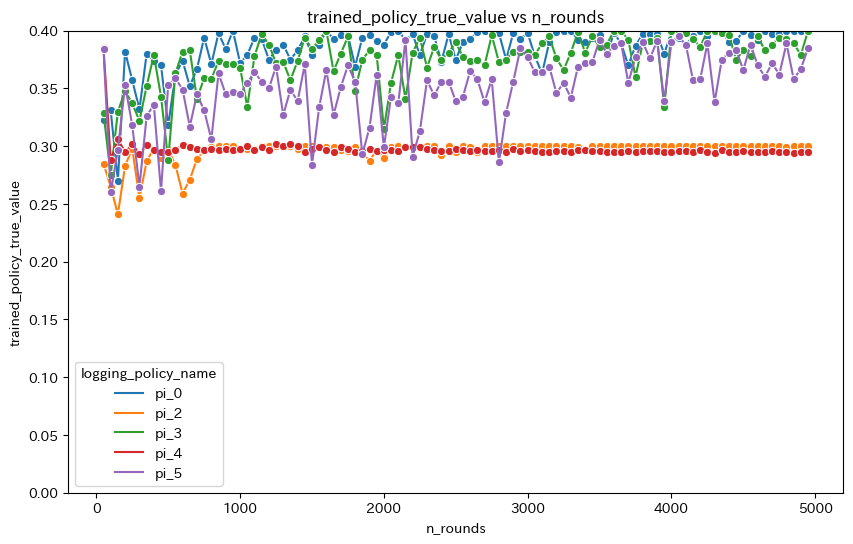

In [28]:
import seaborn as sns

# 横軸 n_rounds, 縦軸 真の性能 のグラフを描画
# グラフの描画
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=rounded_opl_result_df.to_pandas(),
    x="n_rounds",
    y="trained_policy_true_value",
    hue="logging_policy_name",
    marker="o",
)
# plt.xscale("log")
plt.xlabel("n_rounds")
plt.ylabel("trained_policy_true_value")
plt.ylim(0.0, 0.4)
plt.title("trained_policy_true_value vs n_rounds")
plt.legend(title="logging_policy_name")
plt.show()

In [29]:
rounded_opl_result_df.write_csv("logs/logging_policy_experiment/opl_result.csv")